In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

In [60]:
# Data generating

np.random.seed(37)
X = np.vstack(((np.random.randn(150, 2)  + np.array([3, 0])),
               (np.random.randn(100, 2)  + np.array([-3.5, 0.5])),
               (np.random.randn(100, 2) + np.array([-0.5, -2])),
               (np.random.randn(150, 2) + np.array([-2, -2.5])),
               (np.random.randn(150, 2) + np.array([-5.5, -3]))))

In [61]:
print('First five examples: ', X[:5])
print('X.shape:', X.shape)

First five examples:  [[ 2.94553639  0.67430807]
 [ 3.34664703 -1.30034617]
 [ 4.51851188  0.98982371]
 [ 3.2776809  -0.44858935]
 [ 3.96196624 -0.82757864]]
X.shape: (650, 2)


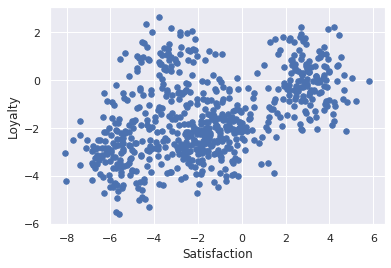

In [62]:
plt.scatter(X[:, 0], X[:, 1], s=30)
plt.xlabel('Satisfaction')
plt.ylabel('Loyalty')
ax = plt.gca()

In [63]:
# KMeans

class KMeans(object):
    """
    Parameters:
    -----------
    X -- np.array
        Matrix of input features
    k -- int
        Number of clusters
    """
    
    def __init__(self, X, k):
        self.X = X
        self.k = k
        
    def initialize_centroids(self):
        """ 
        Returns:
        
        Array of shape (k, n_features), 
            containing k centroids from the initial points
        """        
        
        # use shuffle with random state = 100, and pick first k points                
        
        np.random.seed(100)
        k = self.k
        X_for_shuffle = self.X.copy()
        np.random.shuffle(X_for_shuffle)
        
        return X_for_shuffle[:k]        
             
    def closest_centroid(self, centroids):
        """
        Returns:
        
        Array of shape (n_examples, ), 
            containing index of the nearest centroid for each point
        """        
        
        n_examples = self.X.shape[0]
        n_features = centroids.shape[1]
        k = centroids.shape[0]
        closest_centrs = np.full(n_examples, -1)
        for i in range(n_examples):
            min_distance = np.inf
            for j in range(k):                
                row_norm = np.linalg.norm(self.X[i, :] - centroids[j, :])                
                current_distance = np.square(row_norm)
                if current_distance < min_distance:
                    min_distance = current_distance                    
                    closest_centrs[i] = j            
        
        return closest_centrs       
    
    def move_centroids(self, centroids):
        """
        Returns:
        
        Array of shape (n_clusters, n_features),
        containing the new centroids assigned from the points closest to them
        """        
        
        n_clusters = centroids.shape[0]
        n_features = centroids.shape[1]
        closest_centrs = self.closest_centroid(centroids)
        new_centers = np.zeros((n_clusters, n_features))        
        
        for j in range(n_clusters):
            inds = np.where(closest_centrs == j)[0]
            X_subset = self.X[inds]            
            new_centers[j] = np.mean(X_subset, axis=0)
            
        return new_centers
               

    def final_centroids(self):
        """
        Returns:
        
        clusters -- list of arrays, containing points of each cluster
        centroids -- array of shape (n_clusters, n_features),
            containing final centroids 
        
        """        
        
        centroids = self.initialize_centroids()
        closest_centrs = self.closest_centroid(centroids)
        new_centers = self.move_centroids(centroids)
        old_centers = new_centers - 0.5
        
        while not np.array_equal(new_centers, old_centers):
            old_centers = new_centers
            closest_centrs = self.closest_centroid(new_centers)
            new_centers = self.move_centroids(new_centers)
            
        centroids = new_centers
        
        n_clusters = centroids.shape[0]
        clusters = []
        
        for j in range(n_clusters):
            inds = np.where(closest_centrs == j)[0]
            X_subset = self.X[inds]
            clusters.append(X_subset)       

        return clusters, centroids

In [64]:
model = KMeans(X, 3)

In [65]:
centroids = model.initialize_centroids()
print('Random centroids:', centroids)

Random centroids: [[-5.69677786 -4.89576696]
 [-8.01639395 -4.20027408]
 [-4.56052433  1.58914035]]


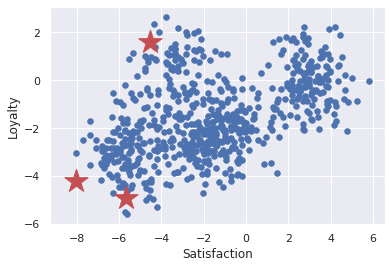

In [66]:
plt.scatter(X[:, 0], X[:, 1], s=30)
plt.scatter(centroids[:,0], centroids[:,1], s=600, marker='*', c='r')
plt.xlabel('Satisfaction')
plt.ylabel('Loyalty')
ax = plt.gca()

In [67]:
closest = model.closest_centroid(centroids)
print('Closest centroids:', closest[:10])

Closest centroids: [2 2 2 2 2 2 2 2 2 2]


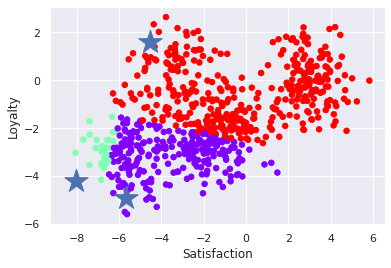

In [68]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=closest, cmap='rainbow')
plt.scatter(centroids[:,0], centroids[:,1], s=600, marker='*', c='b')
plt.xlabel('Satisfaction')
plt.ylabel('Loyalty')
ax = plt.gca()

In [69]:
next_centroids = model.move_centroids(centroids)
print('Next centroids:', next_centroids)

Next centroids: [[-3.46284012 -3.13822882]
 [-6.86311746 -2.89686506]
 [-0.14433424 -0.44447514]]


In [70]:
clusters, final_centrs = model.final_centroids()
print('Final centroids:', final_centrs)
print('Clusters points:', clusters[0][0], clusters[1][0], clusters[2][0])

Final centroids: [[-1.85075523 -1.5126305 ]
 [-5.35643324 -2.80009326]
 [ 2.91476941 -0.12596915]]
Clusters points: [-2.85012507 -0.77129955] [-5.73089369 -0.18855257] [2.94553639 0.67430807]


In [71]:
# mean distances

def mean_distances(k, X):
    """
    Arguments:
    
    k -- int, number of clusters
    X -- np.array, matrix of input features
    
    Returns:
    
    Array of shape (k, ), containing mean of sum distances 
        from centroid to each point in the cluster for k clusters
    """    
    
    sum_distances = np.zeros(k)    
    
    for g in range(1, k+1):
        model = KMeans(X, g)
        clusters, final_centrs = model.final_centroids()
        cluster_distance = np.zeros(g)
        for j in range(g):
            n_examples = clusters[j].shape[0]
            current_distance = np.zeros(n_examples)
            for i in range(n_examples):
                row_norm = np.linalg.norm(clusters[j][i] - final_centrs[j])                
                current_distance[i] = np.square(row_norm)
            cluster_distance[j] = np.sum(current_distance)
        sum_distances[g-1] = np.sum(cluster_distance) / g
        
    return sum_distances

In [72]:
print('Mean distances: ', mean_distances(10, X)) 

Mean distances:  [8350.90848673 1755.47187315  685.51975066  322.55856169  226.47242612
  155.85343331  122.92591829   98.98063889   79.97373072   61.9645739 ]


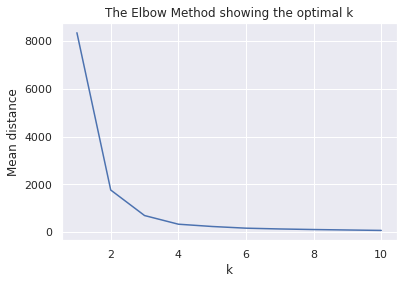

In [73]:
k_clusters = range(1, 11)
distances = mean_distances(10, X)
plt.plot(k_clusters, distances)
plt.xlabel('k')
plt.ylabel('Mean distance')
plt.title('The Elbow Method showing the optimal k')
plt.show()

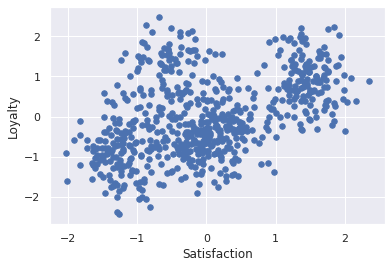

In [75]:
# Solving the problem using sklearn

from sklearn.cluster import KMeans
from sklearn import preprocessing

data = preprocessing.scale(X)
plt.scatter(data[:, 0], data[:, 1], s=30)

plt.xlabel('Satisfaction')
plt.ylabel('Loyalty')
ax = plt.gca()

In [76]:
kmeans = KMeans(3)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

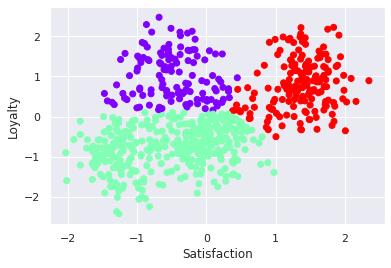

In [77]:
plt.scatter(data[:, 0], data[:, 1], c=kmeans.predict(data), cmap='rainbow')

plt.xlabel('Satisfaction')
plt.ylabel('Loyalty')
ax = plt.gca()

In [78]:
kmeans.inertia_

420.83588876872955

In [79]:
kmeans.cluster_centers_

array([[-0.47281743,  1.02370329],
       [-0.4934678 , -0.76092039],
       [ 1.36682942,  0.79560838]])

In [80]:
kmeans = KMeans(4)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

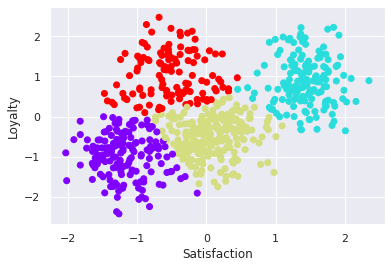

In [81]:
plt.scatter(data[:, 0], data[:, 1], c=kmeans.predict(data), cmap='rainbow')

plt.xlabel('Satisfaction')
plt.ylabel('Loyalty')
ax = plt.gca()